In [1]:
import os

import numpy as np
import torch

import lib.dataset.dataset2D as dataUtils
from lib.dataset.dataset2D import Dataset2D
from lib.hybridnet.modules.efficienttrack.efficienttrack import EfficientTrack

from lib.config.project_manager import ProjectManager

project = ProjectManager()
project.load('Ralph_Center_Test')

#project.create_new(
#    name = 'Face_Pretrain',
#    dataset2D_path = '/home/trackingsetup/Documents/Vortex/datasets/WFLW_Set',
#    dataset3D_path = None)

cfg = project.get_cfg()

Successfully loaded project Ralph_Center_Test!


In [2]:
training_set = Dataset2D(project.cfg, set='train', mode = 'center')
val_set = Dataset2D(project.cfg, set='val',mode = 'center')

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [3]:
weights = '/home/trackingsetup/Downloads/EfficientTrack-d2_100.pth'

efficientTrack = EfficientTrack('train', cfg, None)

Initializing weights...


In [4]:
efficientTrack.train(training_set, val_set, 1000)

  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 0/1000. Loss: 34.28966. Acc: 38.055


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 1/1000. Loss: 24.47112. Acc: 30.242


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 2/1000. Loss: 21.41868. Acc: 21.642


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 3/1000. Loss: 22.21407. Acc: 13.665


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 4/1000. Loss: 20.65126. Acc: 16.988


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 5/1000. Loss: 22.10436. Acc: 22.528


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 6/1000. Loss: 19.14019. Acc: 17.691


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 7/1000. Loss: 17.46853. Acc: 12.424


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 8/1000. Loss: 15.78746. Acc: 11.111


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 9/1000. Loss: 16.51742. Acc: 23.805


  0%|          | 0/789 [00:00<?, ?it/s]

checkpoint...
Val. Epoch: 10/1000. Loss: 18.04732. Acc: 10.298


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 11/1000. Loss: 16.03098. Acc: 12.658


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 12/1000. Loss: 16.31080. Acc: 8.450


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 13/1000. Loss: 16.42577. Acc: 7.293


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 14/1000. Loss: 17.76209. Acc: 13.224


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 15/1000. Loss: 15.10724. Acc: 13.065


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 16/1000. Loss: 14.02951. Acc: 11.918


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 17/1000. Loss: 13.13710. Acc: 10.464


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 18/1000. Loss: 15.50348. Acc: 8.807


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 19/1000. Loss: 15.00893. Acc: 19.436


  0%|          | 0/789 [00:00<?, ?it/s]

checkpoint...
Val. Epoch: 20/1000. Loss: 15.06140. Acc: 17.351


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 21/1000. Loss: 13.29861. Acc: 7.130


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 22/1000. Loss: 14.31822. Acc: 16.496


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 23/1000. Loss: 13.78544. Acc: 14.861


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 24/1000. Loss: 13.63503. Acc: 11.675


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 25/1000. Loss: 14.04371. Acc: 16.205


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 26/1000. Loss: 14.22048. Acc: 20.083


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 27/1000. Loss: 13.15207. Acc: 8.837


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 28/1000. Loss: 14.17915. Acc: 15.092


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 29/1000. Loss: 12.43307. Acc: 16.856


  0%|          | 0/789 [00:00<?, ?it/s]

checkpoint...
Val. Epoch: 30/1000. Loss: 12.27439. Acc: 13.375


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 31/1000. Loss: 13.34474. Acc: 10.888


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 32/1000. Loss: 13.02249. Acc: 11.575


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 33/1000. Loss: 13.85383. Acc: 4.488


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 34/1000. Loss: 13.02607. Acc: 15.267


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 35/1000. Loss: 13.61560. Acc: 10.587


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 36/1000. Loss: 12.50672. Acc: 8.057


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 37/1000. Loss: 13.42641. Acc: 15.480


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 38/1000. Loss: 12.87683. Acc: 15.360


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 39/1000. Loss: 13.84083. Acc: 14.823


  0%|          | 0/789 [00:00<?, ?it/s]

checkpoint...
Val. Epoch: 40/1000. Loss: 13.30377. Acc: 9.883


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 41/1000. Loss: 13.46112. Acc: 12.284


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 42/1000. Loss: 13.57269. Acc: 12.441


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 43/1000. Loss: 13.64333. Acc: 7.565


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 44/1000. Loss: 12.91819. Acc: 11.934


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 45/1000. Loss: 14.34259. Acc: 9.864


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 46/1000. Loss: 12.17050. Acc: 12.954


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 47/1000. Loss: 12.59161. Acc: 12.188


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 48/1000. Loss: 12.15943. Acc: 7.707


  0%|          | 0/789 [00:00<?, ?it/s]

Epoch    50: reducing learning rate of group 0 to 2.0000e-04.
Val. Epoch: 49/1000. Loss: 13.89309. Acc: 19.204


  0%|          | 0/789 [00:00<?, ?it/s]

checkpoint...
Val. Epoch: 50/1000. Loss: 10.85817. Acc: 7.798


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 51/1000. Loss: 11.07103. Acc: 16.678


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 52/1000. Loss: 10.75491. Acc: 8.662


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 53/1000. Loss: 10.68345. Acc: 10.494


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 54/1000. Loss: 10.44274. Acc: 11.462


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 55/1000. Loss: 10.87783. Acc: 15.047


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 56/1000. Loss: 10.46100. Acc: 11.472


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 57/1000. Loss: 11.12749. Acc: 11.538


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 58/1000. Loss: 10.48683. Acc: 6.755


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 59/1000. Loss: 10.62345. Acc: 10.494


  0%|          | 0/789 [00:00<?, ?it/s]

checkpoint...
Val. Epoch: 60/1000. Loss: 10.24739. Acc: 7.532


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 61/1000. Loss: 10.65956. Acc: 6.425


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 62/1000. Loss: 10.62509. Acc: 5.874


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 63/1000. Loss: 10.51316. Acc: 7.527


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 64/1000. Loss: 10.88267. Acc: 11.338


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 65/1000. Loss: 11.23194. Acc: 6.514


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 66/1000. Loss: 11.15283. Acc: 7.862


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 67/1000. Loss: 10.23288. Acc: 6.416


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 68/1000. Loss: 10.91862. Acc: 6.455


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 69/1000. Loss: 10.76172. Acc: 7.280


  0%|          | 0/789 [00:00<?, ?it/s]

checkpoint...
Val. Epoch: 70/1000. Loss: 10.46931. Acc: 6.384


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 71/1000. Loss: 10.66769. Acc: 5.234


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 72/1000. Loss: 11.27424. Acc: 8.634


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 73/1000. Loss: 10.74613. Acc: 8.597


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 74/1000. Loss: 10.82958. Acc: 8.221


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 75/1000. Loss: 10.71193. Acc: 8.646


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 76/1000. Loss: 10.97156. Acc: 6.979


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 77/1000. Loss: 10.93703. Acc: 6.490


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 78/1000. Loss: 10.48675. Acc: 8.339


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 79/1000. Loss: 10.98231. Acc: 7.125


  0%|          | 0/789 [00:00<?, ?it/s]

checkpoint...
Val. Epoch: 80/1000. Loss: 10.50710. Acc: 6.952


  0%|          | 0/789 [00:00<?, ?it/s]

Epoch    82: reducing learning rate of group 0 to 5.0000e-05.
Val. Epoch: 81/1000. Loss: 11.62939. Acc: 8.041


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 82/1000. Loss: 10.96307. Acc: 8.016


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 83/1000. Loss: 10.87804. Acc: 8.006


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 84/1000. Loss: 10.90721. Acc: 8.005


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 85/1000. Loss: 10.76440. Acc: 7.456


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 86/1000. Loss: 10.84432. Acc: 7.451


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 87/1000. Loss: 10.80776. Acc: 7.984


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 88/1000. Loss: 10.72065. Acc: 7.999


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 89/1000. Loss: 10.67214. Acc: 7.442


  0%|          | 0/789 [00:00<?, ?it/s]

checkpoint...
Val. Epoch: 90/1000. Loss: 10.73414. Acc: 6.932


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 91/1000. Loss: 10.85112. Acc: 6.953


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 92/1000. Loss: 10.90135. Acc: 6.951


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 93/1000. Loss: 10.91115. Acc: 6.354


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 94/1000. Loss: 10.89606. Acc: 6.376


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 95/1000. Loss: 10.76863. Acc: 6.350


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 96/1000. Loss: 10.75044. Acc: 6.931


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 97/1000. Loss: 10.76846. Acc: 6.925


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 98/1000. Loss: 10.97650. Acc: 6.946


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 99/1000. Loss: 10.80430. Acc: 6.358


  0%|          | 0/789 [00:00<?, ?it/s]

checkpoint...
Val. Epoch: 100/1000. Loss: 10.76142. Acc: 7.974


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 101/1000. Loss: 10.74038. Acc: 5.827


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 102/1000. Loss: 10.81907. Acc: 5.847


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 103/1000. Loss: 10.73472. Acc: 6.406


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 104/1000. Loss: 10.78598. Acc: 6.933


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 105/1000. Loss: 10.77021. Acc: 6.387


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 106/1000. Loss: 11.22418. Acc: 6.444


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 107/1000. Loss: 10.90410. Acc: 5.828


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 108/1000. Loss: 11.04566. Acc: 6.430


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 109/1000. Loss: 10.96612. Acc: 6.378


  0%|          | 0/789 [00:00<?, ?it/s]

checkpoint...
Val. Epoch: 110/1000. Loss: 10.93698. Acc: 6.934


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 111/1000. Loss: 10.67161. Acc: 5.824


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 112/1000. Loss: 10.53624. Acc: 5.825


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 113/1000. Loss: 10.80124. Acc: 5.844


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 114/1000. Loss: 10.73899. Acc: 6.397


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 115/1000. Loss: 11.02021. Acc: 5.855


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 116/1000. Loss: 10.96517. Acc: 6.365


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 117/1000. Loss: 11.04980. Acc: 6.366


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 118/1000. Loss: 10.70567. Acc: 6.343


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 119/1000. Loss: 10.86822. Acc: 6.394


  0%|          | 0/789 [00:00<?, ?it/s]

checkpoint...
Val. Epoch: 120/1000. Loss: 11.02867. Acc: 6.428


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 121/1000. Loss: 10.86743. Acc: 5.831


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 122/1000. Loss: 10.74246. Acc: 7.479


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 123/1000. Loss: 10.81688. Acc: 7.479


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 124/1000. Loss: 11.00157. Acc: 6.346


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 125/1000. Loss: 10.82932. Acc: 6.398


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 126/1000. Loss: 11.03178. Acc: 6.366


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 127/1000. Loss: 11.07179. Acc: 6.372


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 128/1000. Loss: 10.91901. Acc: 7.476


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 129/1000. Loss: 10.87267. Acc: 8.023


  0%|          | 0/789 [00:00<?, ?it/s]

checkpoint...
Val. Epoch: 130/1000. Loss: 10.91633. Acc: 7.238


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 131/1000. Loss: 10.92104. Acc: 5.827


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 132/1000. Loss: 10.89313. Acc: 5.820


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 133/1000. Loss: 11.26424. Acc: 8.059


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 134/1000. Loss: 11.19751. Acc: 6.370


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 135/1000. Loss: 11.48614. Acc: 6.368


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 136/1000. Loss: 11.24177. Acc: 6.354


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 137/1000. Loss: 11.07073. Acc: 6.343


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 138/1000. Loss: 11.12323. Acc: 5.600


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 139/1000. Loss: 11.36681. Acc: 6.367


  0%|          | 0/789 [00:00<?, ?it/s]

checkpoint...
Val. Epoch: 140/1000. Loss: 11.35003. Acc: 7.781


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 141/1000. Loss: 11.29465. Acc: 6.383


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 142/1000. Loss: 11.32310. Acc: 6.388


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 143/1000. Loss: 11.47926. Acc: 5.864


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 144/1000. Loss: 11.09708. Acc: 6.925


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 145/1000. Loss: 11.15070. Acc: 8.324


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 146/1000. Loss: 10.75959. Acc: 5.790


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 147/1000. Loss: 10.87713. Acc: 5.794


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 148/1000. Loss: 11.00492. Acc: 5.820


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 149/1000. Loss: 11.02618. Acc: 5.066


  0%|          | 0/789 [00:00<?, ?it/s]

checkpoint...
Val. Epoch: 150/1000. Loss: 11.11943. Acc: 5.077


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 151/1000. Loss: 11.26210. Acc: 7.517


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 152/1000. Loss: 11.40112. Acc: 5.866


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 153/1000. Loss: 11.14843. Acc: 6.368


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 154/1000. Loss: 11.41867. Acc: 6.407


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 155/1000. Loss: 11.21617. Acc: 5.835


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 156/1000. Loss: 11.04562. Acc: 5.833


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 157/1000. Loss: 11.28113. Acc: 5.265


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 158/1000. Loss: 11.04324. Acc: 6.942


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 159/1000. Loss: 11.17231. Acc: 5.832


  0%|          | 0/789 [00:00<?, ?it/s]

checkpoint...
Val. Epoch: 160/1000. Loss: 11.37056. Acc: 5.848


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 161/1000. Loss: 11.23148. Acc: 5.824


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 162/1000. Loss: 11.22506. Acc: 5.838


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 163/1000. Loss: 11.28076. Acc: 5.091


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 164/1000. Loss: 11.53379. Acc: 5.091


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 165/1000. Loss: 11.32461. Acc: 5.097


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 166/1000. Loss: 11.22987. Acc: 5.849


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 167/1000. Loss: 11.42490. Acc: 5.859


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 168/1000. Loss: 11.62447. Acc: 5.885


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 169/1000. Loss: 11.40972. Acc: 5.103


  0%|          | 0/789 [00:00<?, ?it/s]

checkpoint...
Val. Epoch: 170/1000. Loss: 11.24328. Acc: 5.081


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 171/1000. Loss: 11.49523. Acc: 4.526


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 172/1000. Loss: 11.50127. Acc: 5.103


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 173/1000. Loss: 11.26694. Acc: 5.077


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 174/1000. Loss: 11.33872. Acc: 5.095


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 175/1000. Loss: 11.11849. Acc: 5.833


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 176/1000. Loss: 11.61428. Acc: 5.886


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 177/1000. Loss: 11.64965. Acc: 5.879


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 178/1000. Loss: 11.43887. Acc: 5.845


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 179/1000. Loss: 11.44284. Acc: 5.834


  0%|          | 0/789 [00:00<?, ?it/s]

checkpoint...
Val. Epoch: 180/1000. Loss: 11.63322. Acc: 4.729


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 181/1000. Loss: 11.38347. Acc: 5.260


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 182/1000. Loss: 11.34936. Acc: 5.836


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 183/1000. Loss: 11.56532. Acc: 6.439


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 184/1000. Loss: 11.61364. Acc: 5.849


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 185/1000. Loss: 11.77001. Acc: 5.857


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 186/1000. Loss: 11.67574. Acc: 5.862


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 187/1000. Loss: 11.63993. Acc: 5.865


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 188/1000. Loss: 11.60939. Acc: 5.851


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 189/1000. Loss: 11.55272. Acc: 5.854


  0%|          | 0/789 [00:00<?, ?it/s]

checkpoint...
Val. Epoch: 190/1000. Loss: 11.58323. Acc: 5.863


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 191/1000. Loss: 11.89842. Acc: 5.880


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 192/1000. Loss: 11.96927. Acc: 5.134


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 193/1000. Loss: 11.95311. Acc: 5.872


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 194/1000. Loss: 11.80754. Acc: 5.879


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 195/1000. Loss: 11.93148. Acc: 5.135


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 196/1000. Loss: 11.74832. Acc: 5.859


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 197/1000. Loss: 12.23856. Acc: 6.439


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 198/1000. Loss: 12.09503. Acc: 5.884


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 199/1000. Loss: 12.04209. Acc: 5.887


  0%|          | 0/789 [00:00<?, ?it/s]

checkpoint...
Val. Epoch: 200/1000. Loss: 11.66314. Acc: 5.106


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 201/1000. Loss: 11.58950. Acc: 5.867


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 202/1000. Loss: 11.77692. Acc: 5.855


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 203/1000. Loss: 11.77405. Acc: 5.879


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 204/1000. Loss: 11.73534. Acc: 4.006


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 205/1000. Loss: 11.96022. Acc: 4.021


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 206/1000. Loss: 12.14372. Acc: 4.019


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 207/1000. Loss: 11.78719. Acc: 4.763


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 208/1000. Loss: 11.80419. Acc: 4.756


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 209/1000. Loss: 11.95046. Acc: 4.767


  0%|          | 0/789 [00:00<?, ?it/s]

checkpoint...
Val. Epoch: 210/1000. Loss: 11.91368. Acc: 4.778


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 211/1000. Loss: 11.91248. Acc: 4.770


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 212/1000. Loss: 11.79771. Acc: 5.303


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 213/1000. Loss: 11.51832. Acc: 5.334


  0%|          | 0/789 [00:00<?, ?it/s]

Val. Epoch: 214/1000. Loss: 11.67935. Acc: 5.881


  0%|          | 0/789 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [5]:
import lib.hybridnet.modules.efficienttrack.darkpose as darkpose
import cv2
import matplotlib.pyplot as plt

weights = "/home/trackingsetup/Documents/Vortex/projects/Ralph_Center_Test/models/efficienttrack/Run_20211118-092800/EfficientTrack-d0_210.pth"

efficientTrack = EfficientTrack('inference', cfg, weights)

[[[245.44347]]]


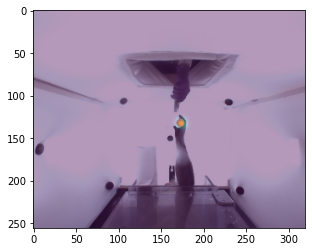

In [47]:
j = 0
item = val_set.__getitem__(j)
j += 40
imgs = item[0]
img = ((imgs*cfg.DATASET.STD)+cfg.DATASET.MEAN)*255

imgs = torch.from_numpy(imgs).permute(2, 0, 1).float()

imgs = imgs.reshape(1,3,256,320)
imgs = imgs.cuda()
outputs = efficientTrack.model(imgs)
preds, maxvals = darkpose.get_final_preds(outputs[1].clamp(0,255).detach().cpu().numpy(), None)

print (maxvals)

colors = [(255,0,0), (255,0,0),(255,0,0),(255,0,0),(0,255,0),(0,255,0),(0,255,0),(0,255,0),(0,0,255),(0,0,255),(0,0,255),(0,0,255),(255,255,0),(255,255,0),(255,255,0), (255,255,0),
                  (0,255,255),(0,255,255),(0,255,255),(0,255,255), (255,0,255),(100,0,100),(100,0,100)]
for i,point in enumerate(preds[0]):
    if (maxvals[0][i]) > 10:
        cv2.circle(img, (int(point[0]*2), int(point[1])*2), 2, (255,100,100), thickness=5)
    else:
        cv2.circle(img, (int(point[0]*2), int(point[1])*2), 2, (100,100,100), thickness=5)

plt.imshow(img/255.)
hetamap = cv2.resize(outputs[1].clamp(0,255).detach().cpu().numpy()[0][0]/255., (320,256), interpolation=cv2.cv2.INTER_NEAREST)
plt.imshow(hetamap, alpha=0.4)
plt.imsave( 'test.png',img/255.)
#plt.savefig('test.png')